### Gravity current simulations from Andrea's lab configuration

See http://grupo-ioa.atmosfera.unam.mx/images/archivos_portal/tesis/TesisM_AndreaB.pdf

Numerical configuration based on https://mitgcm.readthedocs.io/en/latest/examples/plume_on_slope/plume_on_slope.html customized to lab scale. (2D model)

* 640 x 120 grid points (nx x nz)
* Non-hydrostatic
* Density difference through salinity, constant T, both active (tAlpha=1.E-4, sBeta =7.E-4, T0=15 C) 
* Non-linear advection scheme for T and S (33), no explicit diffusivity (adv scheme is already diffusive enough)
* Viscosity Ah = Av = 5E-6 mˆ2 sˆ-1 (molecular)
* No-slip = False (free slip bottom boundary condition)
* Free surface
* Open boundary downstream (W/ Orlanski Cmax=0.45, cVelTimeScale=1000. ? check this!), closed upstream.
* Horizontal resolution 2.3 mm, vertical resolution 1.7 mm
* Time step 0.0025 s


In this notebook: Smooth vs rough topography, $\Gamma = 0.014$ through salinities $S_c=55$, $S_a=34.4$.


**CHECK! : Initial condition salinity**

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cmo

In [10]:
# Functions

def rho(T,S):
    alpha = 1E-4
    beta = 7E-4
    rhoref = 999
    rho = rhoref*(1+alpha*(T)+beta*(S))
    return(rho)

def gamma(rho_c, rho_a):
    return((rho_c-rho_a)/rho_a)

def init_sal():
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.S[0,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.haline, vmin=34.4, vmax=55)
    plt.colorbar(pc, ax=ax, label='Salinity')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[0].data)

def init_sal_r():
    pc = ax.pcolormesh(grid_r.X, 100*grid_r.Z, 
                       np.ma.masked_array(state_r.S[0,:,0,:], mask=mask_r[:,0,:]), 
                       cmap=cmo.cm.haline, vmin=34.4, vmax=55)
    plt.colorbar(pc, ax=ax, label='Salinity')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[0].data)
 
def animate_sal(tt,ax,grid,state,mask):
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.S[tt,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.haline, vmin=34.4, vmax=55)
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[tt].data)

def init_w():
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.W[0,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.balance, vmin=-0.05, vmax=0.05)
    plt.colorbar(pc, ax=ax, label='Vertical velocity')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[0].data)

def init_w_r():
    pc = ax.pcolormesh(grid_r.X, 100*grid_r.Z, 
                       np.ma.masked_array(state_r.W[0,:,0,:], mask=mask_r[:,0,:]), 
                       cmap=cmo.cm.balance, vmin=-0.05, vmax=0.05)
    plt.colorbar(pc, ax=ax, label='Vertical velocity')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[0].data)

def animate_w(tt,ax,grid,state,mask):
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.W[tt,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.balance, vmin=-0.05, vmax=0.05)
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[tt].data)

def rho_lin(T,S):
    alpha = 1E-4
    beta = 7E-4
    rhoref = 999
    rho = rhoref*(np.ones(np.shape(T))-alpha*(T)+beta*(S))
    return(rho)

def gamma(rho_c, rho_a):
    return((rho_c-rho_a)/rho_a)
    
def calc_N2(rho,rho_ref, z, g=9.81):
    '''Calculate Brunt-Vaisala frequency in the Boussinesq limit
    Input: rho: potential density
           rho_ref: constant reference potential density
           z: height array
           g: gravitational acceleration, default value is 9.81 msˆ{-2}
    Output: N2: squared Brunt-Vaisala frequency calulated as 
                Nˆ2 = (g/rho_ref)*(\partial rho/\partial z) 
    '''
    N2 = (g/rho_ref)*(rho[2:,...] - rho[0:-2,...])/((z[2:,...]-z[1:-1,...])+(z[1:-1,...]-z[0:-2,...]))
    return N2
    

In [3]:
# Load model results
grid = xr.open_dataset('/Users/Karina/Tools/MITgcm/verification/gravity_current/smooth/gridGlob.nc')
state = xr.open_dataset('/Users/Karina/Tools/MITgcm/verification/gravity_current/smooth/stateGlob.nc')

masked = np.ma.masked_less_equal(grid.HFacC,0)
mask = np.ma.getmask(masked)

grid_r = xr.open_dataset('/Users/Karina/Tools/MITgcm/verification/gravity_current/tlaloc/gridGlob.nc')
state_r = xr.open_dataset('/Users/Karina/Tools/MITgcm/verification/gravity_current/tlaloc/stateGlob.nc')

masked_r = np.ma.masked_less_equal(grid_r.HFacC,0)
mask_r = np.ma.getmask(masked_r)

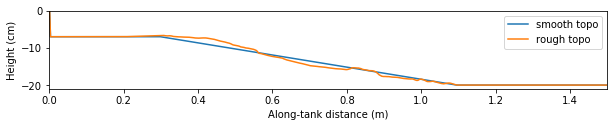

In [4]:
# Compare topographies
fig, ax = plt.subplots(1,1, figsize=(10,2.5))

ax.plot(grid.X,-grid.Depth[0,:]*100, label = 'smooth topo')
ax.plot(grid_r.X,-grid_r.Depth[0,:]*100, label='rough topo')
ax.set_xlabel('Along-tank distance (m)')
ax.set_ylabel('Height (cm)')
ax.set_xlim(0,1.5)
ax.set_ylim(-21,0)
ax.set_aspect(0.01)
ax.legend()

In [5]:
T = 15
Sa = 34.4
Sc = 55

rho_a = rho(T, Sa)
rho_c = rho(T, Sc)
print('Gamma is')
print(gamma(rho_c, rho_a))

Gamma is
0.01406033659002698


### Animations

In [6]:
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128 # para animaciones dentro del notebook de mas de 2Mb
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

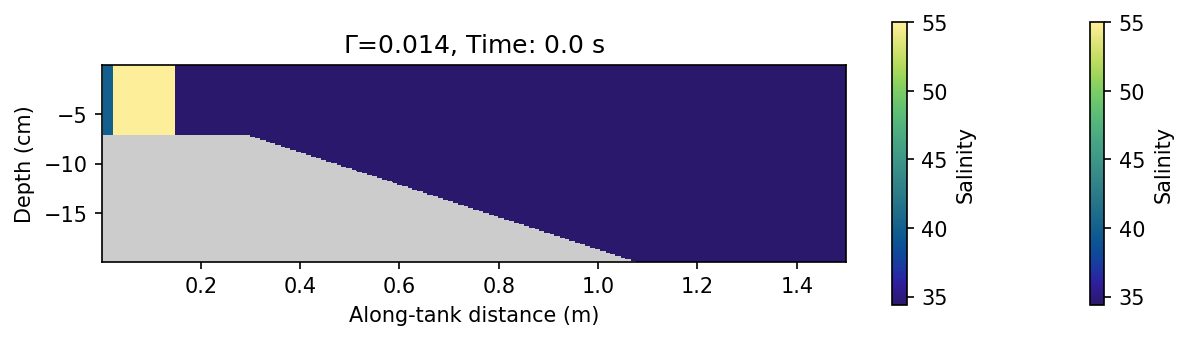

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,2.5))
ax.set_facecolor('0.8')

nt = len(state.T)

anim_sal = matplotlib.animation.FuncAnimation(fig, 
                                              animate_sal, 
                                              init_func=init_sal,
                                              fargs=(ax,grid,state, mask),
                                              frames=nt)
anim_sal

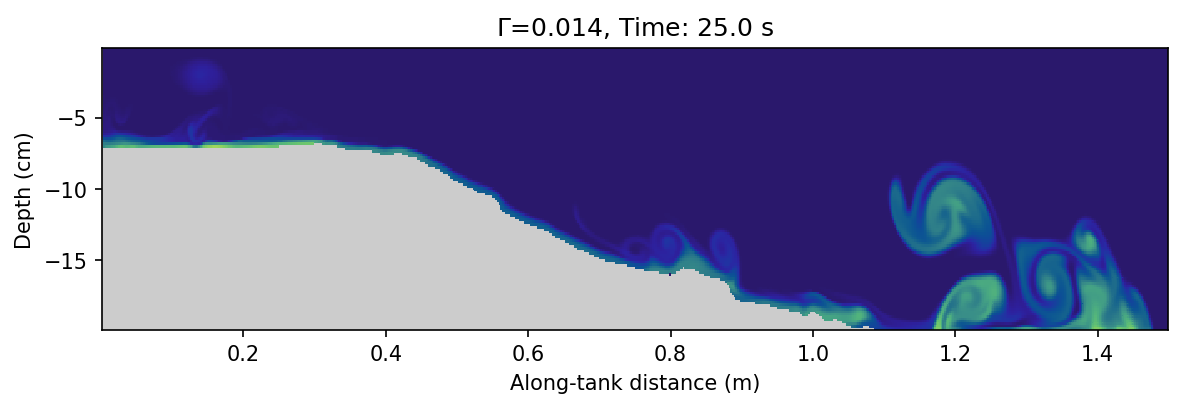

In [12]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,2.5))
ax2.set_facecolor('0.8')

nt = len(state_r.T)

anim_sal_r = matplotlib.animation.FuncAnimation(fig2, 
                                                animate_sal, 
                                                init_func=init_sal_r,
                                                fargs=(ax2,grid_r,state_r, mask_r),
                                                frames=nt)
anim_sal_r

#### Vertical velocity

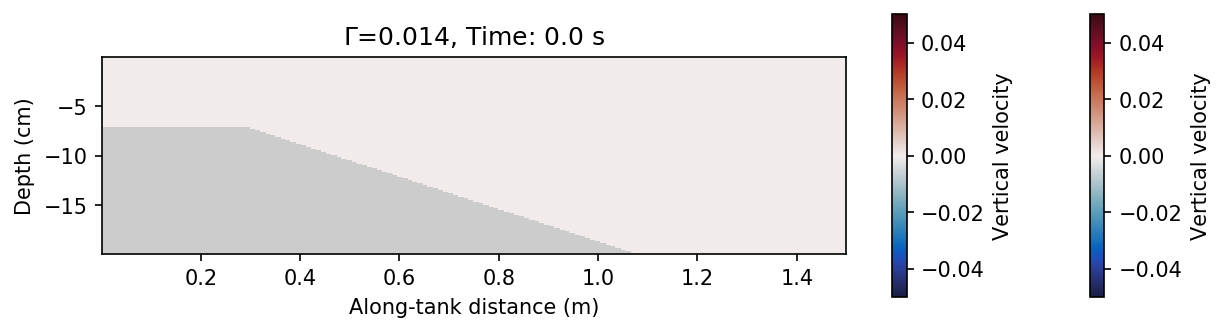

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,2.5))
ax.set_facecolor('0.8')

nt = len(state.T)

anim_w = matplotlib.animation.FuncAnimation(fig, 
                                            animate_w, 
                                            init_func=init_w,
                                            fargs=(ax,grid,state,mask),
                                            frames=nt)
anim_w

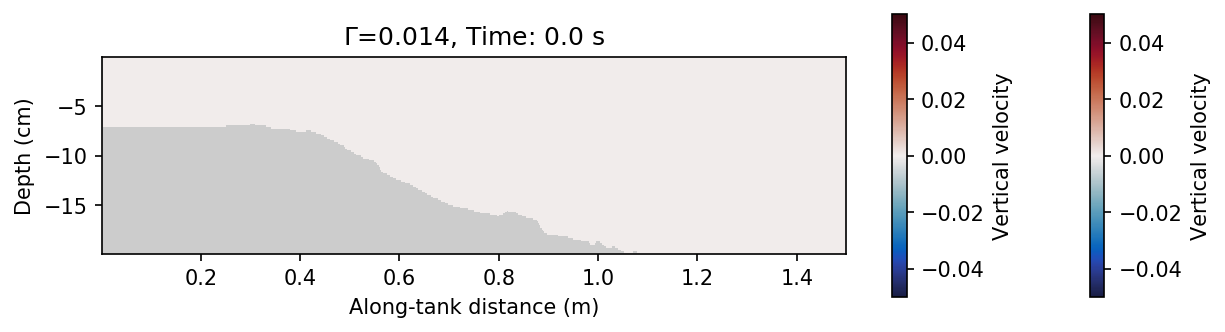

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,2.5))
ax.set_facecolor('0.8')

nt = len(state_r.T)

anim_w_r = matplotlib.animation.FuncAnimation(fig, 
                                              animate_w, 
                                              init_func=init_w_r,
                                              fargs=(ax,grid_r,state_r,mask_r),
                                              frames=nt)
anim_w_r

#### Buoyancy frequency

Later...

### Save frames

In [ ]:
for tt in range(0,len(state.T), 1):
    fig, ax = plt.subplots(1,1, figsize=(10,2.5))
    ax.set_facecolor('0.8')
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.S[tt,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.haline, vmin=34.4, vmax=55)
    plt.colorbar(pc, ax=ax, label='Salinity')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along-tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[tt].data)
    #plt.savefig('gamma14_%02d.png' %state.T[tt].data, format='png')

In [ ]:
for tt in range(0,len(state.T),2):
    fig, ax = plt.subplots(1,1, figsize=(10,2.5))
    pc = ax.pcolormesh(grid.X, 100*grid.Z, 
                       np.ma.masked_array(state.W[tt,:,0,:], mask=mask[:,0,:]), 
                       cmap=cmo.cm.balance, vmin=-0.05, vmax=0.05)
    plt.colorbar(pc, ax=ax, label=r'Vertical velocity (m s$^{-1}$)')
    ax.set_aspect(0.02)
    ax.set_xlabel('Along tank distance (m)')
    ax.set_ylabel('Depth (cm)')
    ax.set_title('$\Gamma$=0.014, Time: %1.1f s' %state.T[tt].data)
    #plt.savefig('w_gamma14_%02d.png' %state.T[tt].data, format='png')